# The main algorithm for regression in PEST is the Gauss-Levenberg-Marquardt (GLM)  algorithm



In [1]:
%matplotlib inline
import os, sys, shutil
sys.path.append('..')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyemu
import zipfile
plt.rcParams['font.size']=10
import response_surface as resurf
# flag to decide if run everything or just visualize results
run_all_flag = False

copy the model files over

In [2]:
import freyberg_setup
working_dir = freyberg_setup.WORKING_DIR_KR
pst_name = freyberg_setup.PST_NAME_KR
# note - switching out with the balanced PST file
pst_name=pst_name.replace('.pst','.r3.pst')
freyberg_setup.setup_pest_kr()


if not run_all_flag:
    shutil.copy2(os.path.join('..','freyberg_k_and_r_response_surface','sweep.zip'),
                 os.path.join(working_dir,'sweep.zip'))
    with zipfile.ZipFile(os.path.join(working_dir,'sweep.zip')) as inzip:
        inzip.extractall(working_dir)
        shutil.move(os.path.join(working_dir, pst_name.replace('.r3.pst','.pst')),
                   os.path.join(working_dir,pst_name))


changing model workspace...
   freyberg_kr
FloPy is using the following  executable to run the model: /Users/mnfienen/Documents/GIT/GW1876/activities/freyberg_response_surface_GLM/freyberg_kr/mfnwt

                                  MODFLOW-NWT-SWR1 
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUNDWATER-FLOW MODEL
                             WITH NEWTON FORMULATION
                             Version 1.1.4 4/01/2018                         
                    BASED ON MODFLOW-2005 Version 1.12.0 02/03/2017                       

                    SWR1 Version 1.04.0 09/15/2016                       

 Using NAME file: freyberg.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2018/10/10 18:09:37

 Solving:  Stress period:     1    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:     3    Time step:     1    Groundwater-Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:s

/Users/mnfienen/Documents/GIT/pyemu/pyemu/utils/gw_utils.py:1607: PyemuWarning: Flow out (flout) of grouped segments will be aggregated... 
  warnings.warn("Flow out (flout) of grouped segments will be aggregated... ", PyemuWarning)


writing 'sfr_obs.config' to sfr_obs.config
                                    obsnme     obsval  weight    obgnme
c001fr05c04_19791231  c001fr05c04_19791231  29.135645     0.0  forehead
c001fr16c17_19791231  c001fr16c17_19791231  21.775225     0.0  forehead
noptmax: 0
noptmax: 8


## Let's open up the `PST` file and check out the parameters

In [3]:
inpst = pyemu.Pst(os.path.join(working_dir,pst_name))

In [4]:
inpst.parameter_data

,parnme,partrans,parchglim,parval1,parlbnd,parubnd,pargp,scale,offset,dercom,extra
parnme,,,,,,,,,,,
hk,hk,log,factor,5.00,0.500,50.00,hk,1.0,0.0,1,NaN
porosity,porosity,log,factor,0.01,0.005,0.02,porosity,1.0,0.0,1,NaN
rch_0,rch_0,fixed,factor,1.00,0.500,2.00,rch,1.0,0.0,1,NaN
rch_1,rch_1,fixed,factor,1.00,0.250,3.00,rch,1.0,0.0,1,NaN


## We need to fix porosity and put reasonable bounds on the other parameters

In [14]:
par = inpst.parameter_data
par.loc['hk', 'parlbnd'] = 3
par.loc['hk', 'parubnd'] = 12
par.loc['porosity', 'partrans']='fixed'
inpst.write(os.path.join(working_dir,pst_name))
inpst.parameter_data


noptmax: 250


,parnme,partrans,parchglim,parval1,parlbnd,parubnd,pargp,scale,offset,dercom,extra
parnme,,,,,,,,,,,
hk,hk,log,factor,11.75,3.000,12.00,hk,1.0,0.0,1,NaN
porosity,porosity,fixed,factor,0.01,0.005,0.02,porosity,1.0,0.0,1,NaN
rch_0,rch_0,log,factor,0.75,0.500,2.00,rch,1.0,0.0,1,NaN
rch_1,rch_1,fixed,factor,1.00,0.250,3.00,rch,1.0,0.0,1,NaN


## run the response surface function

In [15]:
if run_all_flag:
    resurf.run_respsurf(par_names=['hk','rch_0'], pstfile=pst_name)

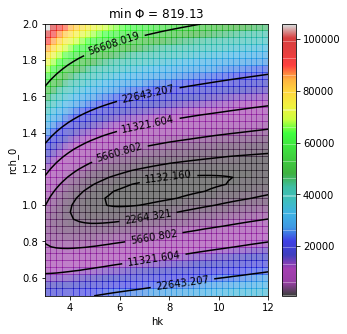

In [16]:
resurf.plot_response_surface(parnames=['hk','rch_0'], pstfile=pst_name);

## Let's evaluate the impact of Lambda on regression (regularization included)

In [41]:
inpst = pyemu.Pst(os.path.join(working_dir,pst_name))
# turn off the Maquardt lambda
inpst.pestpp_options['lambdas']=0.0
inpst.pestpp_options['lambda_scale_fac']=1.0
inpst.pestpp_options['upgrade_augment']='False'

inpst.parameter_data.loc['hk', 'parval1'] = 11.75
inpst.parameter_data.loc['rch_0', 'parval1'] = 1.85
inpst.parameter_data.loc['rch_0', 'partrans'] = 'log'

In [42]:
inpst.parameter_data

,parnme,partrans,parchglim,parval1,parlbnd,parubnd,pargp,scale,offset,dercom,extra
parnme,,,,,,,,,,,
hk,hk,log,factor,11.75,3.000,12.00,hk,1.0,0.0,1,NaN
porosity,porosity,fixed,factor,0.01,0.005,0.02,porosity,1.0,0.0,1,NaN
rch_0,rch_0,log,factor,1.85,0.500,2.00,rch,1.0,0.0,1,NaN
rch_1,rch_1,fixed,factor,1.00,0.250,3.00,rch,1.0,0.0,1,NaN


In [43]:
inpst.control_data.noptmax=250
inpst.write(os.path.join(working_dir,pst_name.replace('.pst','.nolam.pst')))

noptmax: 250


In [44]:
os.chdir(working_dir)
pyemu.os_utils.start_slaves('.', 'pestpp', 
                           pst_name.replace('.pst','.nolam.pst'), 
                           num_slaves=7, master_dir='.')
os.chdir("..")


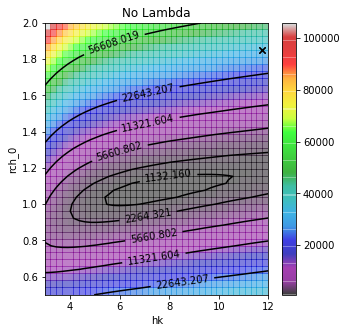

In [45]:
fig, ax = resurf.plot_response_surface(parnames=['hk','rch_0'], pstfile=pst_name);
pars, obfun = resurf.add_trajectory_to_plot(fig,ax, 'nolam','No Lambda', working_dir, pst_name, ['hk','rch_0'])

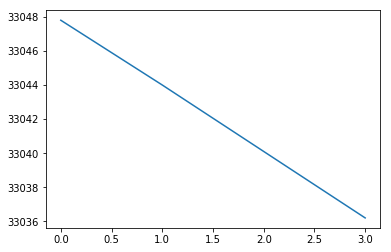

In [46]:
obfun.total_phi.plot()

# Let's try a small value `(1000.0)` for Lambda

In [62]:
inpst = pyemu.Pst(os.path.join(working_dir,pst_name))
# set the Maquardt lambda to 100.0
inpst.pestpp_options['lambdas']=100000.0
inpst.pestpp_options['lambda_scale_fac']=1.0
inpst.pestpp_options['upgrade_augment']='False'


inpst.parameter_data.loc['hk', 'parval1'] = 12.0
inpst.parameter_data.loc['rch_0', 'parval1'] = 0.8
inpst.parameter_data.loc['rch_0', 'partrans'] = 'log'
inpst.control_data.noptmax=250
inpst.write(os.path.join(working_dir,pst_name.replace('.pst','.lam1000.0.pst')))


noptmax: 250


In [63]:
os.chdir(working_dir)
pyemu.os_utils.start_slaves('.', 'pestpp', 
                           pst_name.replace('.pst','.lam1000.0.pst'), 
                           num_slaves=7, master_dir='.')
os.chdir("..")

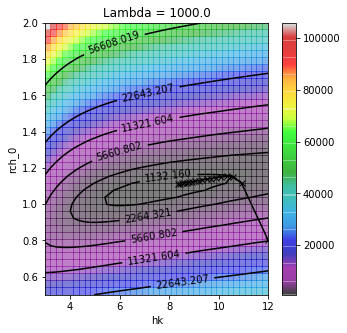

In [64]:
fig, ax = resurf.plot_response_surface(parnames=['hk','rch_0'], pstfile=pst_name);
pars, obfun = add_trajectory_to_plot(fig,ax, 'lam1000.0','Lambda = 1000.0', working_dir, pst_name, ['hk','rch_0'])


### This is RAD! Much better direction! It turns out, we can also do a line search along this better tragectory to 0) make use of idle computer time and 1) avoid overshooting. However, beyond that, it might even make sense to _intentionally_ overshoot a bit.

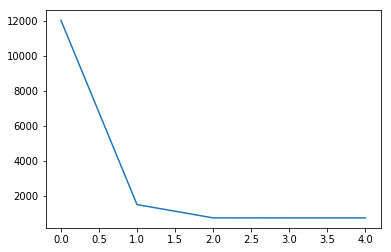

In [61]:
obfun.total_phi.plot()

# Let's try a really big value value `(50.0)` for Lambda

In [17]:
inpst = pyemu.Pst(os.path.join(working_dir,pst_name.replace('.nolam.pst','.lam50.0.pst')))
# set the Maquardt lambda to 1.0
inpst.pestpp_options['lambdas']=50.0
inpst.pestpp_options['lambda_scale_fac']=1.0
inpst.pestpp_options['upgrade_augment']='False'

inpst.parameter_data.loc['hk1', 'parval1'] = 20.0
inpst.parameter_data.loc['cal_flux', 'parval1'] = 4.0
# let's make sure it keeps going even with tiny steps
inpst.control_data.noptmax=550
inpst.control_data.phiredstp=0.000001
inpst.control_data.relparstp=0.000001
inpst.control_data.nphistp=6
inpst.control_data.nrelpar=6
inpst.write(os.path.join(working_dir,pst_name.replace('.pst','.lam50.0.pst')))

In [18]:
os.chdir(working_dir)
pyemu.helpers.start_slaves('.', 'pestpp', 
                           pst_name.replace('.pst','.lam50.0.pst'), 
                           num_slaves=5, master_dir='.')
os.chdir("..")

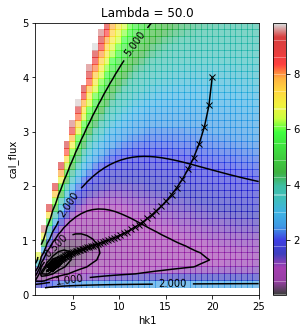

In [19]:
fig, ax = resurf.plot_response_surface(parnames=['hk1', 'cal_flux'], 
                             pstfile=pst_name, WORKING_DIR=working_dir,
                            nanthresh = 10, maxresp=10.0);
pars, obfun = resurf.add_trajectory_to_plot(fig,ax, 'lam50.0','Lambda = 50.0', working_dir, pst_name)

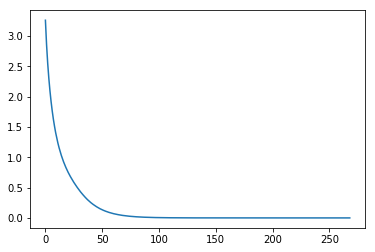

In [20]:
obfun.total_phi.plot()

In [21]:
pars.tail()

,iteration,hk1,cal_flux,fore_flux
264,264,2.50174,0.500100,1
265,265,2.50174,0.500094,1
266,266,2.50152,0.500125,1
267,267,2.50152,0.500117,1
268,268,2.50151,0.500109,1


In [22]:
obfun.tail()

,iteration,model_runs_completed,total_phi,measurement_phi,regularization_phi,obgnme,obgnme_pi
264,264,1315,3.037030e-08,3.037030e-08,0,0.000000,3.037030e-08
265,265,1320,1.026460e-06,1.026460e-06,0,0.000001,2.646030e-08
266,266,1325,4.715000e-08,4.715000e-08,0,0.000000,4.715000e-08
267,267,1330,4.110240e-08,4.110240e-08,0,0.000000,4.110240e-08
268,268,1335,3.583040e-08,3.583040e-08,0,0.000000,3.583040e-08
